# Single-cell workflow (Scanpy)

This notebook loads the concatenated h5ad files and runs a standard Scanpy workflow.


In [27]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from pathlib import Path


import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi

from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from scipy.sparse import issparse

sc.settings.verbosity = 3


import sys
from pathlib import Path

repo_root = Path.cwd().resolve().parent  # if notebook is in analysis/
sys.path.append(str(repo_root / "scripts"))

from plot_spatial_compact_fast import plot_spatial_compact_fast




## Load concatenated data


In [29]:
h5ad_dir = Path('/Volumes/processing2/nature-dev-mouse-reanalysis/data/h5ad')
h5ad_paths = sorted(p for p in h5ad_dir.glob('*.h5ad') if not p.name.startswith('._'))
print(f'Found {len(h5ad_paths)} h5ad files in {h5ad_dir}')
adatas = [sc.read_h5ad(p) for p in h5ad_paths]
adata = sc.concat(adatas, join='outer', merge='unique', label='section', index_unique='-')
adata


Found 22 h5ad files in /Volumes/processing2/nature-dev-mouse-reanalysis/data/h5ad


AnnData object with n_obs × n_vars = 255506 × 119
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'section', 'source_dir'

## QC metrics and filtering


In [30]:
# Basic QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# Inspect thresholds before filtering
adata.obs[['n_genes_by_counts', 'total_counts']].describe()


,n_genes_by_counts,total_counts
count,255506.000000,255506.000000
mean,16.300850,38.760338
std,6.162035,28.606275
min,1.000000,1.000000
25%,12.000000,18.000000
50%,16.000000,30.000000
75%,20.000000,51.000000
max,49.000000,277.000000


In [31]:
# Example filters (adjust based on dataset)
sc.pp.filter_cells(adata, min_genes=5)
sc.pp.filter_genes(adata, min_cells=3)

# Filter out high-mito cells (adjust threshold)
adata


filtered out 1982 cells that have less than 5 genes expressed


AnnData object with n_obs × n_vars = 253524 × 119
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'section', 'source_dir', 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

## Normalization and feature selection


In [32]:
adata.obsm['spatial'] = np.array(adata.obs[['x', 'y']])

In [33]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')
adata = adata[:, adata.var.highly_variable].copy()

sc.pp.scale(adata, max_value=10)

adata


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 253524 × 119
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'section', 'source_dir', 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

## Dimensionality reduction and clustering


In [34]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata, min_dist=0.1)
adata


computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:52)


AnnData object with n_obs × n_vars = 253524 × 119
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'section', 'source_dir', 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Clustering at resolution 0.5...
running Leiden clustering
    finished: found 24 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:01:16)
Done.


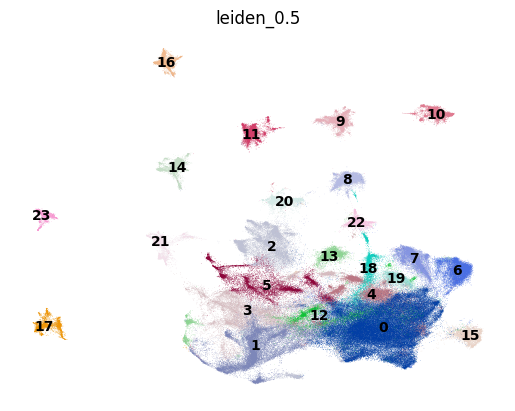

Clustering at resolution 1...
running Leiden clustering


In [ ]:
resolutions = [0.5, 1, 2]

for resolution in resolutions:
    key = f'leiden_{resolution}'

    if key in adata.obs.columns:
        print(f"Skipping {resolution}: {key} already exists.")
    else:
        print(f"Clustering at resolution {resolution}...")
        sc.tl.leiden(adata, resolution=resolution, key_added=key)
        print("Done.")

    # plot UMAP
    sc.pl.umap(adata, color=key, legend_loc='on data', frameon=False)

## Marker genes


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


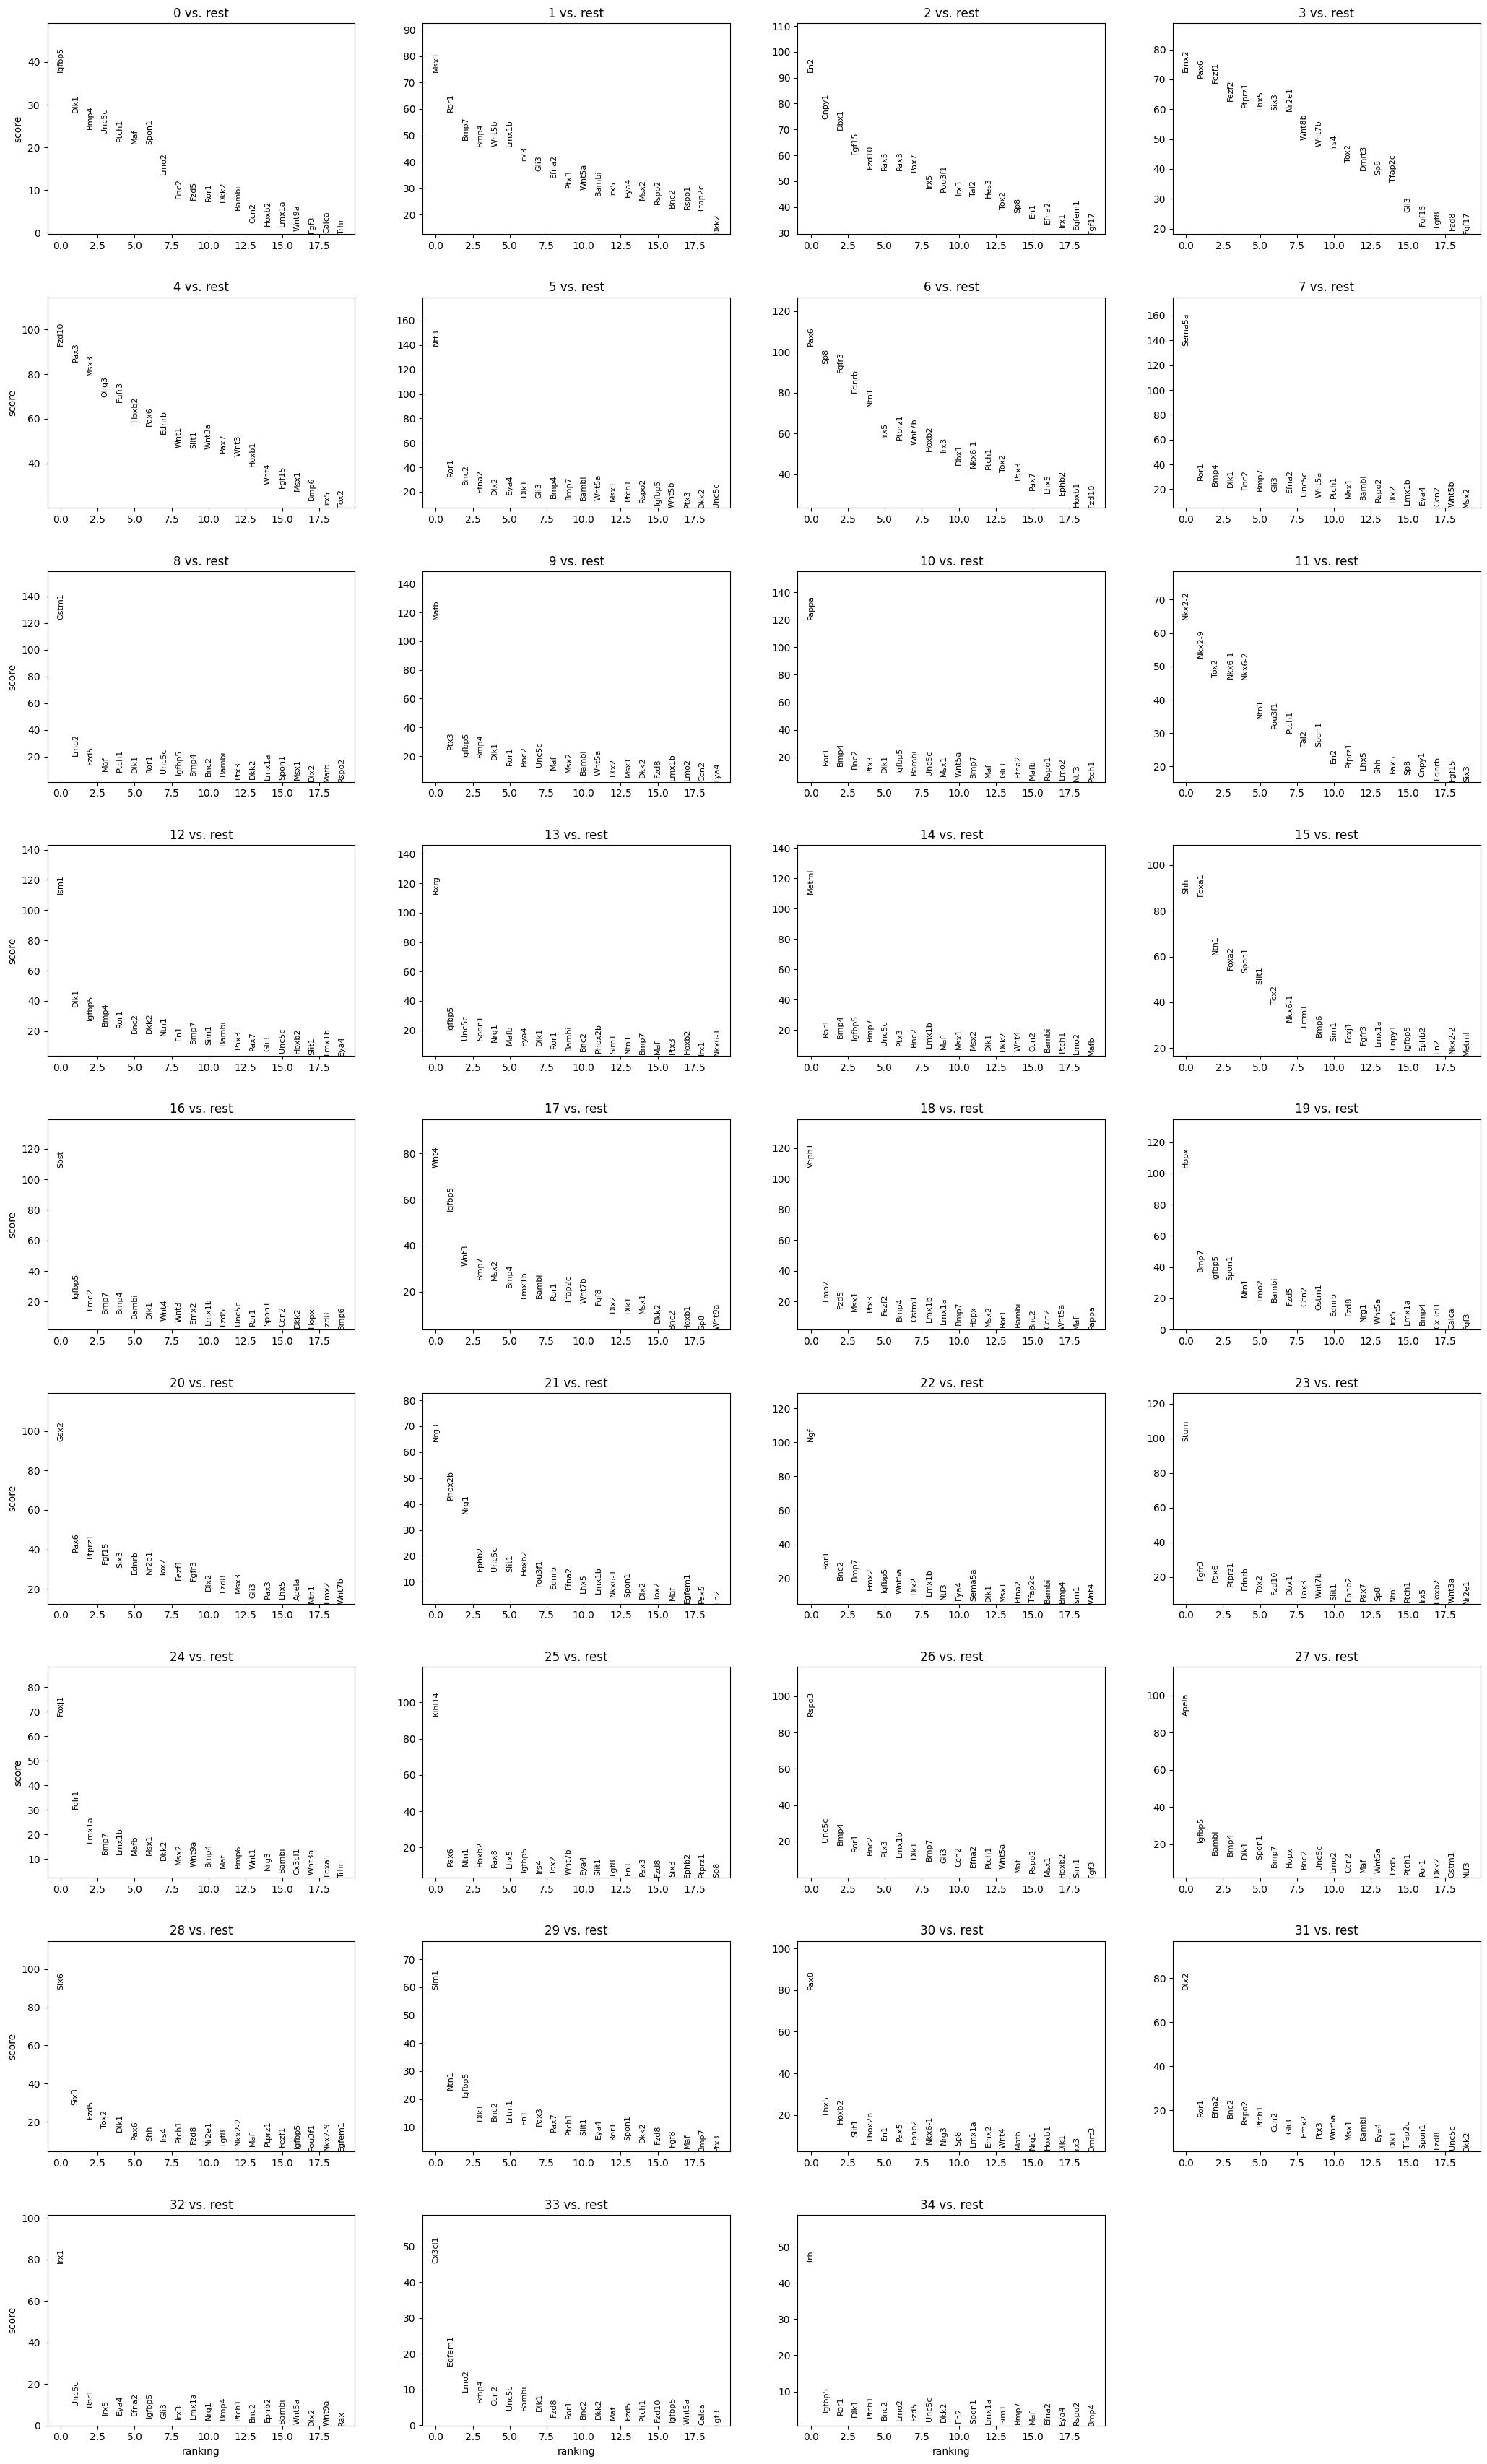

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden_1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


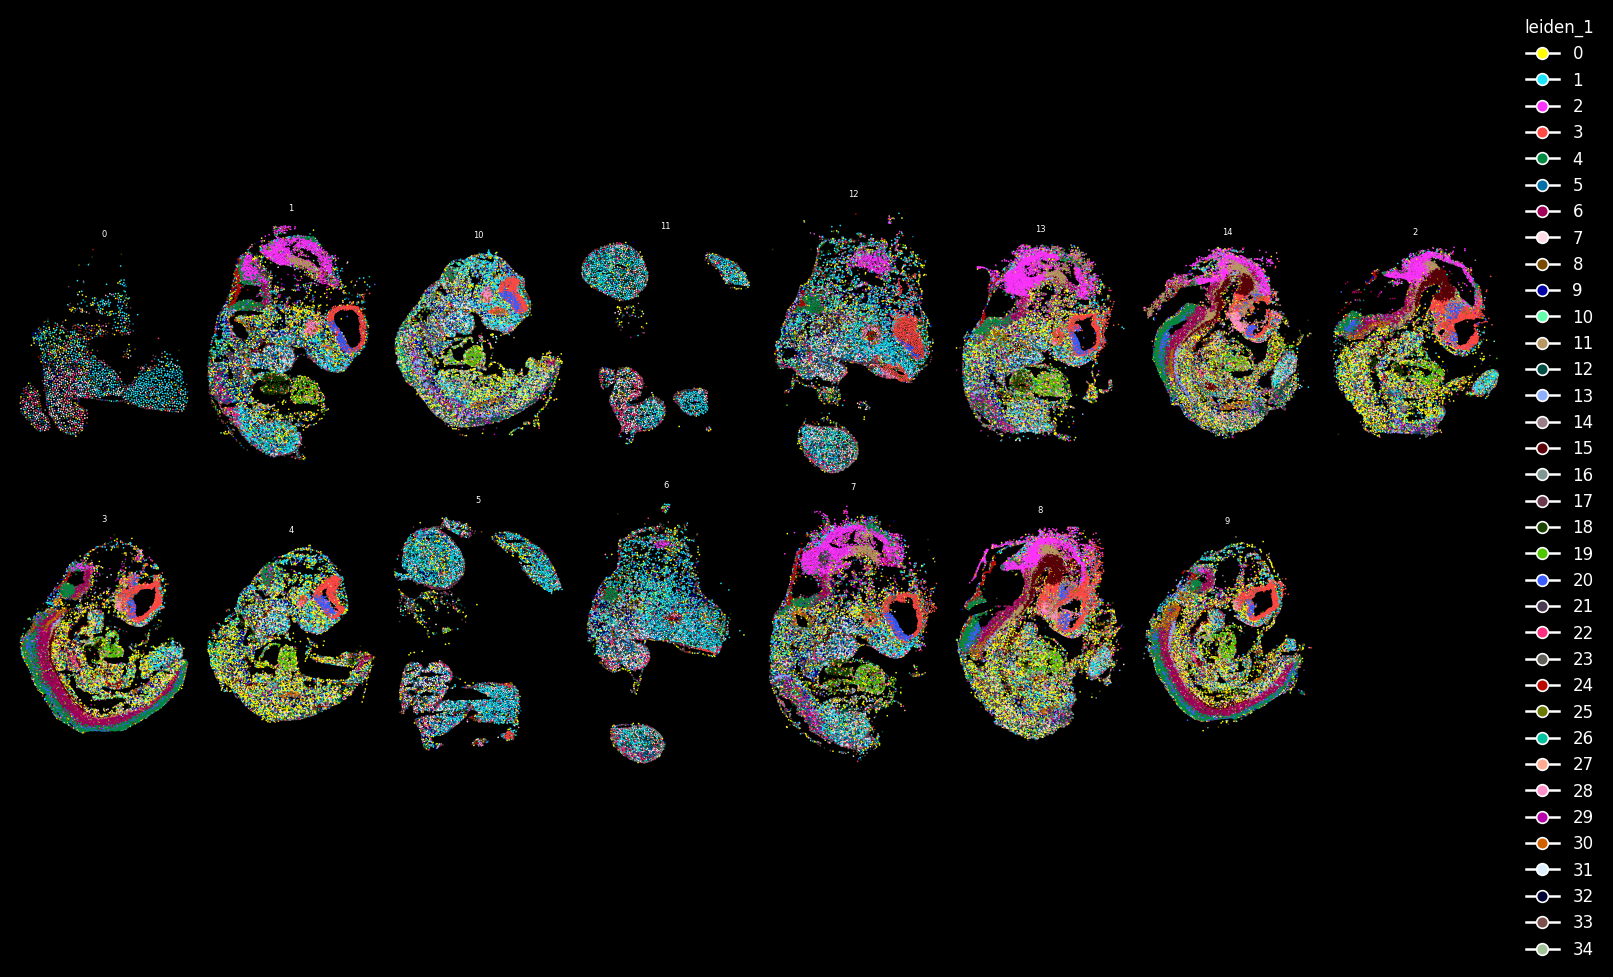

In [ ]:
# usage
plot_spatial_compact_fast(
    adata,
    color="leiden_1",
    groupby="section",
    spot_size=1,
    cols=6,
    height=5,
    legend_col_width=1.0,
    background="black",

)

## Save processed object


In [ ]:
outdir = Path('/Volumes/processing2/nature-dev-mouse-reanalysis')
out_path = outdir / 'ad_all_processed.h5ad'
adata.write(out_path)
out_path


PosixPath('/Volumes/processing2/nature-dev-mouse-reanalysis/data/h5ad/ad_all_processed.h5ad')